# How well do the number of bedrooms/bathrooms and square feet predict the tax-assessed value of single-unit residential properties in three Southern California counties from May to June 2017?

#### Sean Oslin
#### October 21, 2019

## Project planning phase

### Project goal/research question

To predict the values of single-unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

### Deliverables

1. Presentation of the analysis findings usable by management for decision making
2. MySQL notebook with database queries that were imported into Python for analysis
3. Data definitions and analysis notes
4. Data analysis in a Jupyter Notebook that will allow for replication of analysis
5. Github repository holding the analysis and supporting materials

### Minimum viable product

Analysis of how 3 variables (bedroom count, bathroom count and square feet), singlely and in combination predict the tax assessment value for three counties in Southern California as compared to the baseline.

### Null and alternative hypotheses

H<sub>0</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence do not predict the assessed tax value

H<sub>a</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence predict the assessed tax value

## Data acquisition and preparation phases

The sole data source was the Zillow relational database. Data was cleaned and prepared using MySQL and then uploaded to Python for additional preparation and analysis. For detailed information on data preparation please see
https://docs.google.com/document/d/1SUEslxymvGYJ_lEWjufyO8jeRPfs-Z9FXlS1aftjKMQ/edit?usp=sharing

### Python libraries used for analysis

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

### Python programming for this analysis imported from a text editor

In [2]:
import env
import wrangle_z
import z_split_scale

### Import of prepared Zillow data from the text editor to this notebook

In [3]:
df_z = wrangle_z.wrangle_zillow()

### Verification that all null values have been removed

In [4]:
df_z.isnull().sum()

Property Description    0
Number of Bathrooms     0
Number of Bedrooms      0
Square Feet             0
Tax Appraised Value     0
Assessed Tax            0
County Number           0
dtype: int64

### Data types adjusted to best suit each variable

In [5]:
df_z['County Number'] = df_z['County Number'].astype('int64')
df_z['Tax Appraised Value'] = df_z['Tax Appraised Value'].astype('int64')
df_z['Square Feet'] = df_z['Square Feet'].astype('int64')
df_z['Number of Bedrooms'] = df_z['Number of Bedrooms'].astype('float')

### Summary of data types, numbers of rows (individual real estate properties) and data columns

In [6]:
df_z.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 0 to 15962
Data columns (total 7 columns):
Property Description    15963 non-null object
Number of Bathrooms     15963 non-null float64
Number of Bedrooms      15963 non-null float64
Square Feet             15963 non-null int64
Tax Appraised Value     15963 non-null int64
Assessed Tax            15963 non-null float64
County Number           15963 non-null int64
dtypes: float64(3), int64(3), object(1)
memory usage: 997.7+ KB


## Data exploration and pre-processing phases

### Random sample of data

In [7]:
df_z.sample(4)

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
7430,Single Family Residential,2.0,3.0,1749,93806,1488.12,6059
3760,Single Family Residential,2.0,4.0,1737,405000,5593.73,6037
15368,Single Family Residential,2.0,3.0,1653,155160,2444.67,6037
8540,Single Family Residential,3.0,4.0,2202,329843,3356.50,6059


### Descriptive statistics

In [8]:
df_z.describe()

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
count,15963.000000,15963.000000,15963.000000,1.596300e+04,15963.000000,15963.000000
mean,2.215749,3.252835,1837.059199,4.633165e+05,5680.536779,6044.516758
std,1.026447,0.949797,984.656553,6.432976e+05,7465.277971,17.335701
min,1.000000,1.000000,320.000000,1.216800e+04,49.180000,6037.000000
25%,2.000000,3.000000,1233.000000,1.820635e+05,2495.545000,6037.000000
50%,2.000000,3.000000,1592.000000,3.204320e+05,4063.980000,6037.000000
75%,3.000000,4.000000,2162.500000,5.284255e+05,6408.970000,6037.000000
max,20.000000,25.000000,26345.000000,1.912982e+07,228999.210000,6111.000000


### Median values

In [9]:
df_z.median()

Number of Bathrooms         2.00
Number of Bedrooms          3.00
Square Feet              1592.00
Tax Appraised Value    320432.00
Assessed Tax             4063.98
County Number            6037.00
dtype: float64

#### *Mean and median values for bathrooms, bedrooms and square footage are close in value, allowing for an assumption of normality*

### Visualizations of the data set

#### Distribution of the number of bathrooms by assessed tax - there are multiple outliers for assessed taxes for houses with the same number of bathrooms

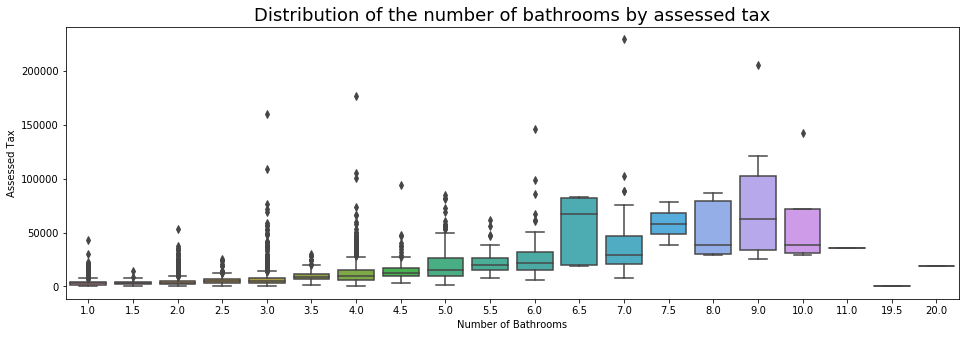

In [10]:
plt.figure(figsize=(16, 5))
ax1 = sns.boxplot(x=df_z["Number of Bathrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bathrooms by assessed tax', fontsize = 18)

#### Distribution of the number of bedrooms by assessed tax - there are multple outliers for assessed taxes for houses with the same number of bedrooms

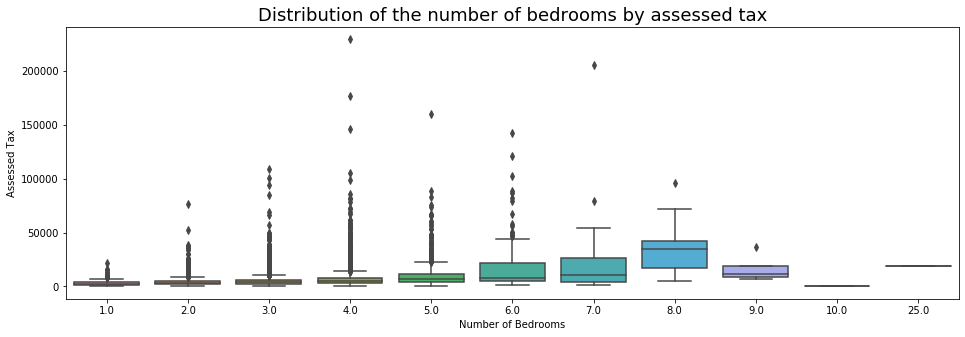

In [11]:
plt.figure(figsize=(16, 5))
ax2 = sns.boxplot(x=df_z["Number of Bedrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bedrooms by assessed tax', fontsize = 18)

#### Histogram of the single-unit square footage - this is a fairly normal distribution with a long tail for mansions

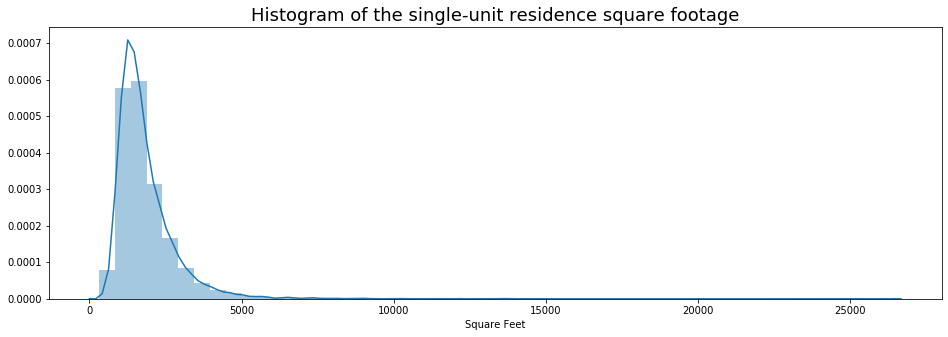

In [66]:
plt.figure(figsize=(16, 5))
ax3 = sns.distplot(df_z['Square Feet'])\
.set_title('Histogram of the single-unit residence square footage', fontsize = 18)

## Inferential data exploration

H<sub>0</sub> : The assessed tax value for single-unit properties with 1 bathroom is the same properties with 3 bathroom are same

H<sub>a</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence predict the assessed tax value

In [13]:
one_bathroom = df_z[df_z['Number of Bathrooms']==1.0]
three_bathroom = df_z[df_z['Number of Bathrooms']==3.0]

In [14]:
stats.ttest_ind(one_bathroom['Tax Appraised Value'], three_bathroom['Tax Appraised Value'])


Ttest_indResult(statistic=-29.789371817851393, pvalue=4.245078428482482e-183)

#### *Reject H<sub>0</sub>. The average appraised tax value of 1 bathroom properties is not the same as the average appraised value of 3 bathroom properties.*

H<sub>0</sub> : The number of bathrooms are not correlated with the number of bedrooms

H<sub>a</sub> : The number of bathrooms are correlated with the number of bedrooms

In [15]:
corr, p = stats.pearsonr(df_z['Number of Bathrooms'], df_z['Number of Bedrooms'])
print('The correlation coefficient is', corr)
print('The p-value is', p)

The correlation coefficient is 0.6574660775103857
The p-value is 0.0


#### *Reject H<sub>0</sub>. The number bathrooms and bedrooms are correlated.*

### Split variables into X and y, then train and test

 #### Remove columns of data not necessary for this phase of the analysis and create a new dataframe for the y variable

In [16]:
X = df_z.drop(columns=['Property Description', 'Tax Appraised Value', 'Assessed Tax', 'County Number'])
y = df_z[['Tax Appraised Value']]

#### Split the modified/new variables into train and test, with 80% of data rows in the two train variables.

In [17]:
x_train, x_test, y_train, y_test = z_split_scale.split_my_data(X,y)

#### Sample of x_train data to verify split and column changes occured

In [18]:
x_train.sample(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
786,2.0,4.0,2222
3948,2.0,3.0,1339


#### Sample of y_test data to verify new column was created and the split occured

In [19]:
y_train.sample(2)

,Tax Appraised Value
2546,95428
1451,262509


## Visualizing the x_train variables

#### Pair plot showing histogram and scatter plot of each combination of x_train variable (i.e. bathrooms, bedrooms and square feet)

Text(0.5, 0.98, 'Histogram and scatter plot for every combinaiton of x_train variable')

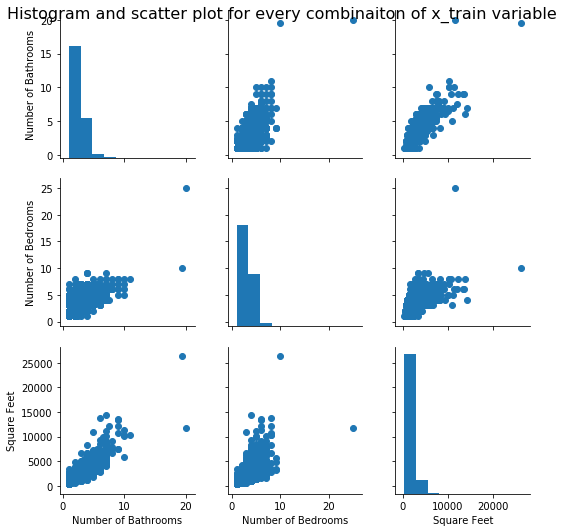

In [20]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.fig.suptitle('Histogram and scatter plot for every combinaiton of x_train variable', fontsize = 16)

## Apply standard scaler to x_train and x_test

#### Because of assumption that the x (dependent) variables are normally distributed, the standard scaler will be used.

In [21]:
train_x_scaled_data, test_x_scaled_data,scaler_x_train, scaler_x_test = z_split_scale.standard_scaler(x_train,x_test)

#### Verify data scaler has transformed independent variables to harmonize the scales among the variables

In [22]:
train_x_scaled_data.head(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
8477,0.278822,-0.262844,-0.054008
10275,-0.207660,0.783780,0.016880


# Data modeling

## Run regression on baseline and 3 models on x_train

In [23]:
predictions=pd.DataFrame({'actual':y_train['Tax Appraised Value']}).reset_index(drop=True)

#model 1 - all 3 variables
lm1=LinearRegression()
lm1.fit(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']],y_train)
lm1_predictions=lm1.predict(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']])
predictions['lm1']=lm1_predictions

#model 2 - just square feet
lm2=LinearRegression()
lm2.fit(train_x_scaled_data[['Square Feet']],y_train)
lm2_predictions=lm2.predict(train_x_scaled_data[['Square Feet']])
predictions['lm2']=lm2_predictions

#model 3 - only number of bedrooms and bathrooms
lm3=LinearRegression()
lm3.fit(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']],y_train)
lm3_predictions=lm3.predict(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']])
predictions['lm3']=lm3_predictions

#baseline model (mean)
predictions['baseline'] = y_train.mean()[0]
predictions.head()

#print(lm1.intercept_,lm1.coef_)

,actual,lm1,lm2,lm3,baseline
0,378038,489000.394632,439752.591875,597899.189244,462043.629601
1,600000,350635.071116,469010.509667,308978.373883,462043.629601
2,274121,544289.115431,860648.637825,517427.056179,462043.629601
3,190192,173113.494416,223661.970469,8181.454481,462043.629601
4,282036,472055.385009,448529.967213,401326.610990,462043.629601


#### Evaluate baseline and 3 models (train)

In [24]:
#Baseline
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print('MSE baseline:', MSE_baseline)
print('SSE baseline:', SSE_baseline)
print('RMSE baseline:', RMSE_baseline)
print('R2 baseline:', r2_baseline)

MSE baseline: 420928611175.0658
SSE baseline: 5375258364705590.0
RMSE baseline: 648790.1133456534
R2 baseline: 0.0


In [25]:
#Model 1: number of bedrooms, number of bathrooms and square feet
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print('MSE model 1 train:', MSE_1)
print('SSE model 1 train:', SSE_1)
print('RMSE model 1 train:', RMSE_1)
print('R2 model 1 train:', r2_1)

MSE model 1 train: 240025152945.04852
SSE model 1 train: 3065121203108269.5
RMSE model 1 train: 489923.6195010897
R2 model 1 train: 0.4297723020656794


In [26]:
#Model 2: square feet only
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print('MSE model 2 train:', MSE_2)
print('SSE model 2 train:', SSE_2)
print('RMSE model 2 train:', RMSE_2)
print('R2 model 2 train:', r2_2)

MSE model 2 train: 250577596757.9224
SSE model 2 train: 3199875910598669.0
RMSE model 2 train: 500577.2635247454
R2 model 2 train: 0.40470286384570275


In [27]:
#Model 3: bedrooms and bathrooms only
MSE_3 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_3 = MSE_3*len(predictions.actual)
RMSE_3 = sqrt(MSE_3)
r2_3 = r2_score(predictions.actual, predictions.lm3)
print('MSE model 3 train:', MSE_3)
print('SSE model 3 train:', SSE_3)
print('RMSE model 3 train:', RMSE_3)
print('R2 model 3 train:', r2_3)

MSE model 3 train: 250577596757.9224
SSE model 3 train: 3199875910598669.0
RMSE model 3 train: 500577.2635247454
R2 model 3 train: 0.2954275801853904


### *** The model with number of bedrooms/bathrooms and square feet performed the best. ***

## Run regression on 3 models using x_test

In [28]:
predictions=pd.DataFrame({'actual':y_test['Tax Appraised Value']}).reset_index(drop=True)

#model 1 - all 3 variables
lm1=LinearRegression()
lm1.fit(test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']],y_test)
lm1_predictions=lm1.predict(test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']])
predictions['lm1']=lm1_predictions

#model 2 - just square feet
lm2=LinearRegression()
lm2.fit(test_x_scaled_data[['Square Feet']],y_test)
lm2_predictions=lm2.predict(test_x_scaled_data[['Square Feet']])
predictions['lm2']=lm2_predictions

#model 3 - only number of bedrooms and bathrooms
lm3=LinearRegression()
lm3.fit(test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']],y_test)
lm3_predictions=lm3.predict(test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']])
predictions['lm3']=lm3_predictions

#baseline model (mean)
predictions['baseline'] = y_test.mean()[0]
predictions.head()

#print(lm1_test.intercept_,lm1_test.coef_)

,actual,lm1,lm2,lm3,baseline
0,208546,110335.050975,44063.789259,94305.571549,468407.313185
1,137176,69330.714266,120357.290723,32679.175250,468407.313185
2,227220,598697.547943,529043.020190,770180.505665,468407.313185
3,220308,779379.803731,807411.201210,708554.109366,468407.313185
4,395686,92299.496693,122831.674555,217054.507854,468407.313185


In [29]:
#Baseline
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print('MSE baseline:', MSE_baseline)
print('SSE baseline:', SSE_baseline)
print('RMSE baseline:', RMSE_baseline)
print('R2 baseline:', r2_baseline)

MSE baseline: 385287176880.51447
SSE baseline: 1230221955779482.8
RMSE baseline: 620715.0528870026
R2 baseline: 0.0


In [30]:
#Model 1 Test: number of bedrooms, number of bathrooms and square feet
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print('MSE model 1 test:', MSE_1)
print('SSE model 1 test:', SSE_1)
print('RMSE model 1 test:', RMSE_1)
print('R2 model 1 test:', r2_1)

MSE model 1 test: 217091968451.87387
SSE model 1 test: 693174655266833.2
RMSE model 1 test: 465931.2915568924
R2 model 1 test: 0.4365450461923923


In [31]:
#Model 2 Test: square feet only
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print('MSE model 2 test:', MSE_2)
print('SSE model 2 test:', SSE_2)
print('RMSE model 2 test:', RMSE_2)
print('R2 model 2 test:', r2_2)

MSE model 2 test: 224254863994.62973
SSE model 2 test: 716045780734852.8
RMSE model 2 test: 473555.55534132395
R2 model 2 test: 0.41795399003332057


In [32]:
#Model 3: bedrooms and bathrooms only
MSE_3 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_3 = MSE_3*len(predictions.actual)
RMSE_3 = sqrt(MSE_3)
r2_3 = r2_score(predictions.actual, predictions.lm3)
print('MSE model 3 test:', MSE_3)
print('SSE model 3 test:', SSE_3)
print('RMSE model 3 test:', RMSE_3)
print('R2 model 3 test:', r2_3)

MSE model 3 test: 224254863994.62973
SSE model 3 test: 716045780734852.8
RMSE model 3 test: 473555.55534132395
R2 model 3 test: 0.3017289005002437


## *R2 values for train and test are comparable*

### Plot_residuals (errors)

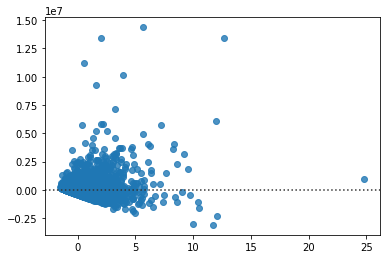

In [33]:
def plot_residuals(x, y):
    return sns.residplot(x, y)

x = train_x_scaled_data[['Square Feet']]
y = y_train[['Tax Appraised Value']]
plot_residuals(x,y)
plt.show()

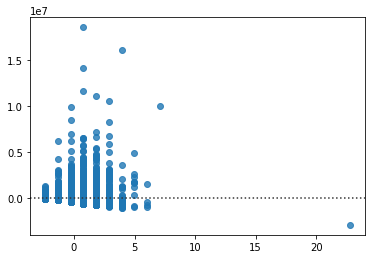

In [34]:
def plot_residuals(x, y):
    return sns.residplot(x, y)

x = train_x_scaled_data[['Number of Bedrooms']]
y = y_train[['Tax Appraised Value']]
plot_residuals(x,y)
plt.show()

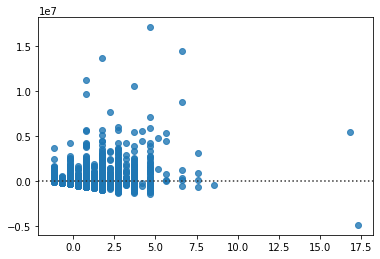

In [35]:
def plot_residuals(x, y):
    return sns.residplot(x, y)

x = train_x_scaled_data[['Number of Bathrooms']]
y = y_train[['Tax Appraised Value']]
plot_residuals(x, y)
plt.show()

## Distribution of tax rates for each county

In [36]:
df_z['County Tax Rates'] = df_z['Assessed Tax']/df_z['Tax Appraised Value']

In [46]:
df_z.drop(columns=['Property Description'], inplace = True)
df_z.head()

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
0,2.0,4.0,1604,498347,6089.82,6037,0.012220
1,3.0,3.0,2384,549917,6679.55,6037,0.012146
2,2.0,3.0,1574,235272,3876.31,6037,0.016476
3,2.0,2.0,1619,340000,4206.15,6037,0.012371
4,3.0,2.0,2408,2017254,24353.42,6037,0.012073


In [47]:
v = df_z[df_z['County Number'] == 6111]
l = df_z[df_z['County Number'] == 6037]
o = df_z[df_z['County Number'] == 6059]

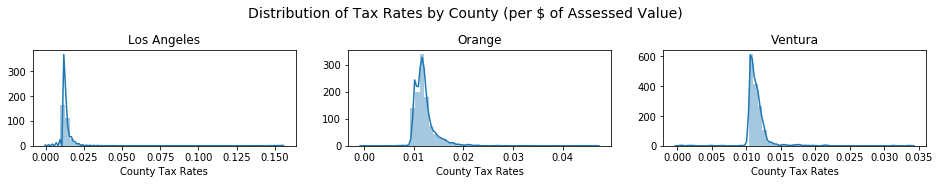

In [48]:
plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of Tax Rates by County (per $ of Assessed Value)', fontsize=14)

plt.subplot(331)
sns.distplot(l['County Tax Rates'])
plt.title('Los Angeles')

plt.subplot(332)
sns.distplot(o['County Tax Rates'])
plt.title('Orange')

plt.subplot(333)
sns.distplot(v['County Tax Rates'])
plt.title('Ventura')
plt.show()

In [49]:
Los_Angeles_County = l.describe()
Los_Angeles_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,12388.000000,12388.000000,12388.000000,1.238800e+04,12388.000000,12388.0,12388.000000
mean,2.149661,3.177510,1772.191637,4.464855e+05,5611.552369,6037.0,0.013736
std,1.045680,0.956073,950.439448,6.415080e+05,7656.803041,0.0,0.003985
min,1.000000,1.000000,320.000000,1.216800e+04,125.950000,6037.0,0.000303
25%,1.000000,3.000000,1197.000000,1.700000e+05,2416.067500,6037.0,0.012147
50%,2.000000,3.000000,1532.000000,2.982050e+05,3911.960000,6037.0,0.012638
75%,3.000000,4.000000,2059.250000,4.944260e+05,6146.047500,6037.0,0.014012
max,20.000000,25.000000,14342.000000,1.912982e+07,228999.210000,6037.0,0.155072


In [61]:
l['County Tax Rates'].median()

0.012638139210671695

### Test for normality of the distribution of County Tax Rates (LA)

In [63]:
stats.normaltest(l['County Tax Rates']) #normally distributed

NormaltestResult(statistic=21374.956321252263, pvalue=0.0)

In [51]:
Orange_County = o.describe()
Orange_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,2780.000000,2780.000000,2780.000000,2.780000e+03,2780.000000,2780.0,2780.000000
mean,2.462050,3.498201,2075.428058,5.483000e+05,6233.562180,6059.0,0.012111
std,0.947383,0.886708,1109.588740,7.094007e+05,7386.973146,0.0,0.002231
min,1.000000,1.000000,388.000000,1.611900e+04,345.720000,6059.0,0.000032
25%,2.000000,3.000000,1415.000000,2.465898e+05,2908.670000,6059.0,0.010805
50%,2.500000,3.000000,1853.000000,4.091510e+05,4706.300000,6059.0,0.011702
75%,3.000000,4.000000,2467.750000,6.488870e+05,7248.965000,6059.0,0.012622
max,19.500000,10.000000,26345.000000,1.168967e+07,121161.260000,6059.0,0.046414


In [57]:
o['County Tax Rates'].median()

0.011701882621223545

### Test for normality of the distribution of County Tax Rates (Orange)

In [64]:
stats.normaltest(o['County Tax Rates']) #normally distributed

NormaltestResult(statistic=2268.7579016083055, pvalue=0.0)

In [52]:
Ventura_County = v.describe()
Ventura_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,795.000000,795.000000,795.000000,7.950000e+02,795.000000,795.0,795.000000
mean,2.384277,3.568553,2014.309434,4.284085e+05,4821.628931,6111.0,0.011491
std,0.819591,0.850999,890.610077,3.268902e+05,3587.999743,0.0,0.001842
min,1.000000,1.000000,572.000000,1.678200e+04,49.180000,6111.0,0.000367
25%,2.000000,3.000000,1444.500000,2.372000e+05,2716.540000,6111.0,0.010695
50%,2.000000,4.000000,1826.000000,3.732460e+05,4299.460000,6111.0,0.011203
75%,3.000000,4.000000,2356.000000,5.423780e+05,6053.900000,6111.0,0.011782
max,7.500000,6.000000,12086.000000,3.631311e+06,38677.720000,6111.0,0.033626


In [56]:
v['County Tax Rates'].median()

0.011202753200564568

### Test for normality of the distribution of County Tax Rates (Ventura)

In [65]:
stats.normaltest(v['County Tax Rates']) #normally distributed

NormaltestResult(statistic=783.2122377044036, pvalue=8.464932569728526e-171)

## Analysis of the mean tax rates across all 3 counties (ANOVA)

#### H<sub>0</sub> The mean tax rate for all three counties is the same.
#### H<sub>a</sub> : The mean tax rate for the three counties is different. 

In [55]:
stats.f_oneway(l['County Tax Rates'], o['County Tax Rates'], v['County Tax Rates'])

F_onewayResult(statistic=331.49634908264215, pvalue=8.768186369395588e-142)

### *Reject H<sub>0</sub>. The tax rates are different. Los Angeles County has the highest rates, followed by Orange and Ventura Counties*